## Code Setup

In [10]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
from birdmaps import bird_runs
import scgt

In [11]:
FILE_PATH = "data/CA-Final"
bird_run = bird_runs.BirdRun(FILE_PATH)

In [12]:
acowoo_run = bird_run.get_bird_run("acowoo", "Acorn Woodpecker")
stejay_run = bird_run.get_bird_run("stejay", "Steller's Jay")
birds = [acowoo_run, stejay_run]


In [13]:
# Reads the set of terrain types that appear. 
terrain = scgt.GeoTiff.from_file(acowoo_run.terrain_fn)
tile = terrain.get_all_as_tile()
terrain_types = sorted(list(np.unique(tile.m)))

In [15]:

def read_resistance_csv(fn):
    """Reads a dictionary of terrain to resistance in csv, producing a dictionary."""
    d = {}
    with open(fn) as f:
        reader = csv.DictReader(f)
        for row in reader:
            d[int(row['map_code'])] = float(row['resistance'])
    return d

def read_histogram_json(fn):
    with open(fn) as f:
        d = json.load(f)
        return {int(k): v for k, v in d.items()}


def write_transmission_csv(resistance, fn):
    """
    :resistance: a dictionary mapping map codes (integers) to resistance values (float)"""
    with open(fn, "w") as f:
        writer = csv.DictWriter(f, fieldnames=['map_code', 'transmission'])
        writer.writeheader()
        for k, v in resistance.items():
            writer.writerow({'map_code': k, 'transmission': v})
            

def plot_histogram(d, title=""):
    xs = list(d.keys())
    xs.sort(reverse=True)
    sxs = [str(x) for x in xs]
    ys = [d[x] for x in xs]
    plt.barh(sxs, ys, label=sxs)
    plt.title(title)
    plt.show()

In [25]:
def merge_resistance_and_observations(resistance_d, observation_d):
    """Merges the resistance histogram with the observation dictionary."""
    # I initialize the transmission using the resistance dictionary.
    transmission = {}
    for t in terrain_types:
        transmission[t] = 1. - resistance_d.get(t, 0.)
    # I compute the max frequency in breeding terrain.\n",
    breeding_freq = max([v for k, v in observation_d.items() if resistance_d.get(k, 1) == 0])
    for t in terrain_types:
        # This is the quality fraction of that terrain wrt. breeding.
        quality_fraction = min(1, observation_d.get(t, 0.) / breeding_freq)
        transmission[t] = max(transmission[t], quality_fraction)
    return transmission


In [26]:
import matplotlib

matplotlib.rc('figure', figsize=(8, 8))

def compute_transmission(bird, show=False):
    """Diagnoses the terrain for a bird, and computes the transmission"""
    resistance_d = read_resistance_csv(bird.resistance_original_fn)
    observation_d = read_histogram_json(bird.terrain_histogram_json_fn)
    transmission = merge_resistance_and_observations(resistance_d, observation_d)
    write_transmission_csv(transmission, bird.transmission_fn)
    if show:
        plot_histogram(resistance_d, title="{} original resistance".format(bird.name))
        plot_histogram(observation_d, title="{} observations".format(bird.name))
        plot_histogram(transmission, title="{} transmission".format(bird.name))
    print("Done", bird.name)

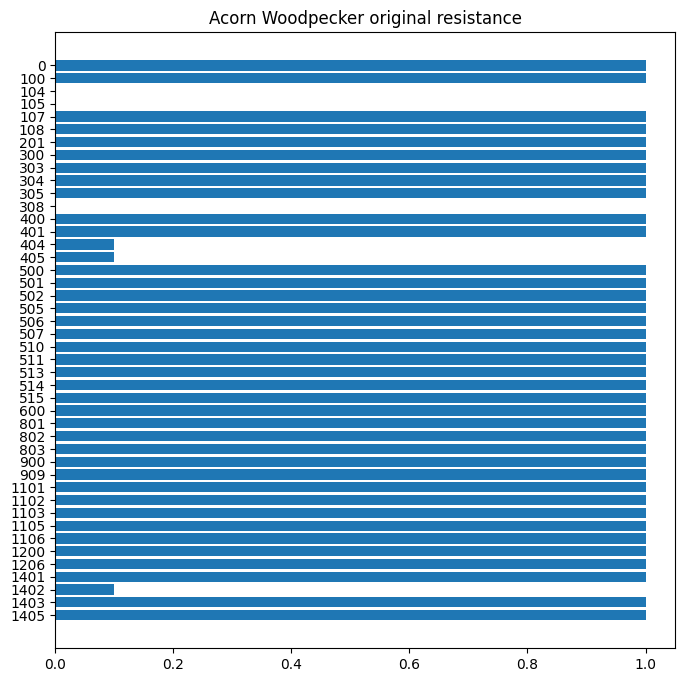

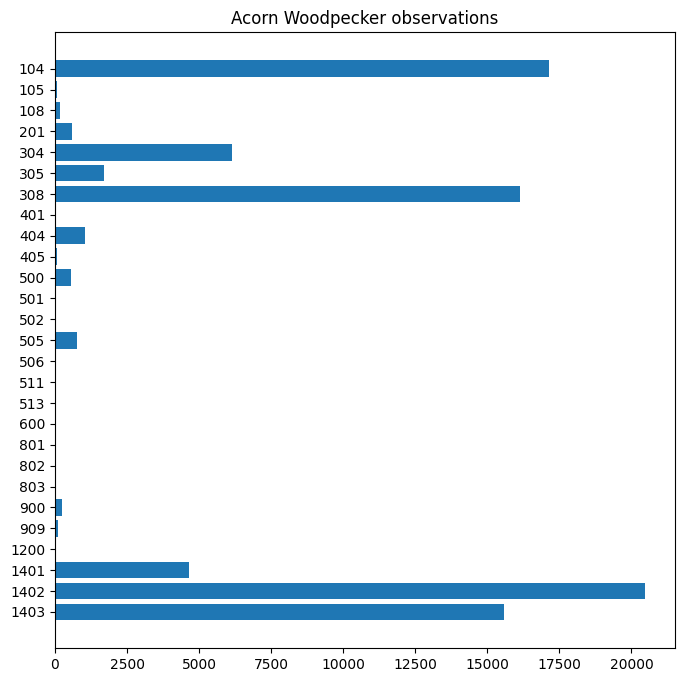

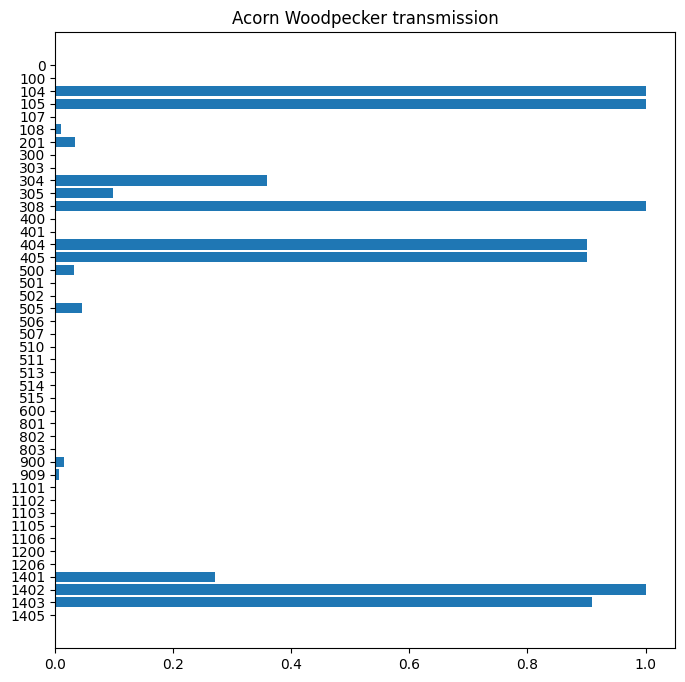

Done Acorn Woodpecker


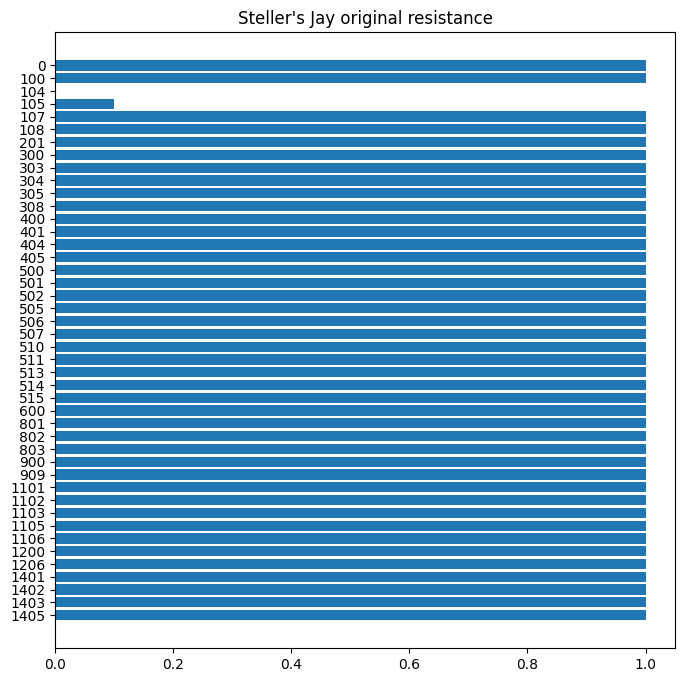

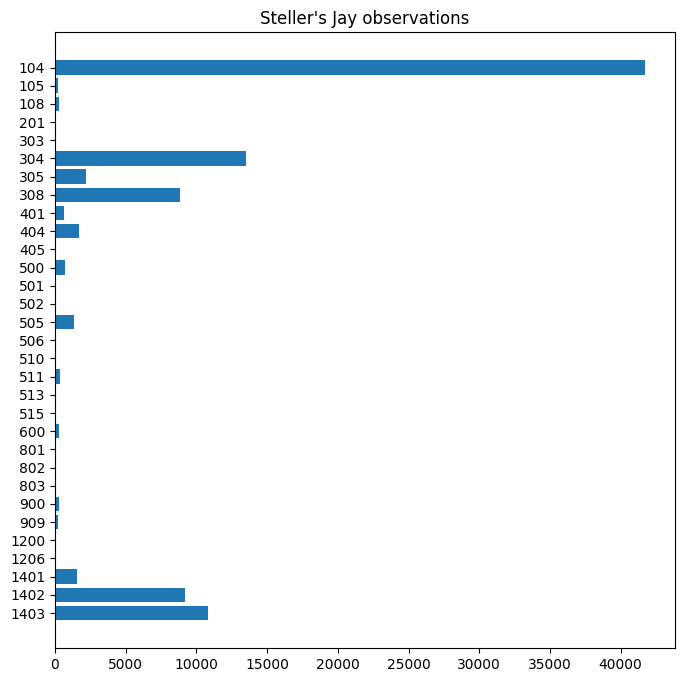

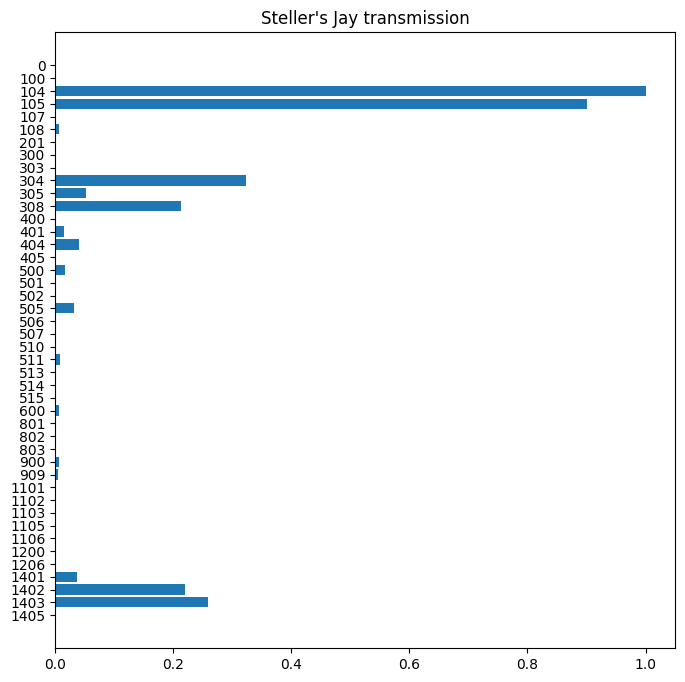

Done Steller's Jay


In [27]:
compute_transmission(acowoo_run, show=True)
compute_transmission(stejay_run, show=True)